In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq self-supervised  # upgrade self-supervised on colab

In [ ]:
#default_exp vision.barlow_twins

# Barlow Twins

> **Barlow Twins**: [Barlow Twins: Self-Supervised Learning via Redundancy Reduction](https://arxiv.org/pdf/2103.03230.pdf)

In [ ]:
#export
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *

## Algorithm

#### Barlow Twins

![SimCLR Framework](images/barlow_twins.png)

**Absract**: Self-supervised learning (SSL) is rapidly closing
the gap with supervised methods on large computer
vision benchmarks. A successful approach
to SSL is to learn representations which are invariant
to distortions of the input sample. However, a
recurring issue with this approach is the existence
of trivial constant representations. Most current
methods avoid such collapsed solutions by careful
implementation details. We propose an objective
function that naturally avoids such collapse by
measuring the cross-correlation matrix between
the outputs of two identical networks fed with distorted
versions of a sample, and making it as close
to the identity matrix as possible. This causes the
representation vectors of distorted versions of a
sample to be similar, while minimizing the redundancy
between the components of these vectors.
The method is called BARLOW TWINS, owing to
neuroscientist H. Barlow’s redundancy-reduction
principle applied to a pair of identical networks.
BARLOW TWINS does not require large batches
nor asymmetry between the network twins such
as a predictor network, gradient stopping, or a
moving average on the weight updates. It allows
the use of very high-dimensional output vectors.
BARLOW TWINS outperforms previous methods
on ImageNet for semi-supervised classification in
the low-data regime, and is on par with current
state of the art for ImageNet classification with
a linear classifier head, and for transfer tasks of
classification and object detection.

**Own Summary**: Barlow Twins uses 2 augmented views of the same image such as SimCLR but it introduces a new loss function which is inspired by [Information Bottleneck](https://en.wikipedia.org/wiki/Information_bottleneck_method). This loss function doesn't rely on large batch size or negative sample requirement as opposed to InfoNCE loss.

Like most other self-supervised vision algorithms Barlow Twins model consists of an `encoder` and a `projector (MLP)` layer. The definition of this module is fairly simple as below.

In [ ]:
#export
class BarlowTwinsModel(Module):
    "An encoder followed by a projector"
    def __init__(self,encoder,projector): self.encoder,self.projector = encoder,projector
    def forward(self,x): return self.projector(self.encoder(x))

Instead of directly using `BarlowTwinsModel` by passing both an `encoder` and a `projector`, `create_barlow_twins_model` function can be used by minimally passing a predefined `encoder` and the expected input channels.

In the paper it's mentioned that MLP layer consists of 3 layers with first 2 layers having batchnorm followed by ReLU. The following function will create a 3 layer MLP projector with batchnorm and ReLU by default. Alternatively, you can change `bn` and `nlayers`. It is also noted in the paper that using larger hidden and projection size increases the downstream task performance.

**Quote from the paper**: Architecture The encoder consists of a ResNet-50 network
(He et al., 2016) (without the final classification layer)
followed by a projector network. The projector network
has three linear layers, each with 8192 output units. The
first two layers of the projector are followed by a batch
normalization layer and rectified linear units.

In [ ]:
#export
def create_barlow_twins_model(encoder, hidden_size=256, projection_size=128, bn=True, nlayers=3):
    "Create Barlow Twins model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector)
    return BarlowTwinsModel(encoder, projector)

You can use `self_supervised.layers` module to create an encoder. It supports all **timm** and **fastai** models available out of the box.

We define number of input channels with `n_in`, projector/mlp's hidden size with `hidden_size`,  projector/mlp's final projection size with `projection_size` and projector/mlp's number of layers with `nlayers`.

In [ ]:
encoder = create_encoder("tf_efficientnet_b0_ns", n_in=3, pretrained=False, pool_type=PoolingType.CatAvgMax)
model = create_barlow_twins_model(encoder, hidden_size=2048, projection_size=128, nlayers=2)
out = model(torch.randn((2,3,224,224))); out.shape

torch.Size([2, 128])

## BarlowTwins Callback

The following parameters can be passed;

- **aug_pipelines** list of augmentation pipelines List[Pipeline] created using functions from `self_supervised.augmentations` module. Each `Pipeline` should be set to `split_idx=0`. You can simply use `get_simclr_aug_pipelines` utility to get aug_pipelines.
- **lmb** $\lambda$ is the weight for redundancy reduction term in the loss function

<center><img src='images/barlow_twins_loss.png'></center>

BarlowTwins algorithm uses 2 views of a given image, and `BarlowTwins` callback expects a list of 2 augmentation pipelines in `aug_pipelines`.

You can simply use helper function `get_barlow_twins_aug_pipelines()` which will allow augmentation related arguments such as size, rotate, jitter...and will return a list of 2 pipelines, which we can be passed to the callback. This function uses `get_multi_aug_pipelines` which then `get_batch_augs`. For more information you may refer to `self_supervised.augmentations` module.

Also, you may choose to pass your own list of aug_pipelines which needs to be List[Pipeline, Pipeline] where Pipeline(..., split_idx=0). Here, `split_idx=0` forces augmentations to be applied in training mode.

In [ ]:
#export
@delegates(get_multi_aug_pipelines)
def get_barlow_twins_aug_pipelines(size, **kwargs): return get_multi_aug_pipelines(n=2, size=size, **kwargs)

In [ ]:
aug_pipelines = get_barlow_twins_aug_pipelines(size=28, rotate=False, jitter=False, bw=False, blur=False, stats=None, cuda=False)
aug_pipelines

[Pipeline: RandomResizedCrop -> RandomHorizontalFlip,
 Pipeline: RandomResizedCrop -> RandomHorizontalFlip]

In [ ]:
#export
class BarlowTwins(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines, lmb=5e-3, print_augs=False):
        assert_aug_pipelines(aug_pipelines)
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('lmb')
        
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
        nf = self.learn.model.projector[-1].out_features
        self.I = torch.eye(nf).to(self.dls.device)
                    
            
    def before_batch(self):
        xi,xj = self.aug1(self.x), self.aug2(self.x)
        self.learn.xb = (torch.cat([xi, xj]),)
        
    
    def lf(self, pred, *yb):
        bs,nf = pred.size(0)//2,pred.size(1)
        z1, z2 = pred[:bs],pred[bs:]
        
        z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
        z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
        
        C = (z1norm.T @ z2norm) / bs 
        cdiff = (C - self.I)**2
        loss = (cdiff*self.I + cdiff*(1-self.I)*self.lmb).sum() 
        return loss

    
    @torch.no_grad()
    def show(self, n=1):
        bs = self.learn.x.size(0)//2
        x1,x2  = self.learn.x[:bs], self.learn.x[bs:] 
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]] 
        return show_batch(x1[0], None, images, max_n=len(images), nrows=n)

### Example Usage

In [ ]:
path = untar_data(URLs.MNIST_TINY)
items = get_image_files(path)
tds = Datasets(items, [PILImageBW.create, [parent_label, Categorize()]], splits=GrandparentSplitter()(items))
dls = tds.dataloaders(bs=5, after_item=[ToTensor(), IntToFloatTensor()], device='cpu')

In [ ]:
fastai_encoder = create_encoder('xresnet18', n_in=1, pretrained=False)
model = create_barlow_twins_model(fastai_encoder, hidden_size=1024, projection_size=1024)
aug_pipelines = get_barlow_twins_aug_pipelines(size=28, rotate=False, jitter=False, bw=False, blur=False, stats=None, cuda=False)
learn = Learner(dls, model, cbs=[BarlowTwins(aug_pipelines, print_augs=True),ShortEpochCallback(0.001)])

Pipeline: RandomResizedCrop -> RandomHorizontalFlip
Pipeline: RandomResizedCrop -> RandomHorizontalFlip


Also, with `show_one()` method you can inspect data augmentations as a sanity check. You can use existing augmentation functions from `augmentations` module.

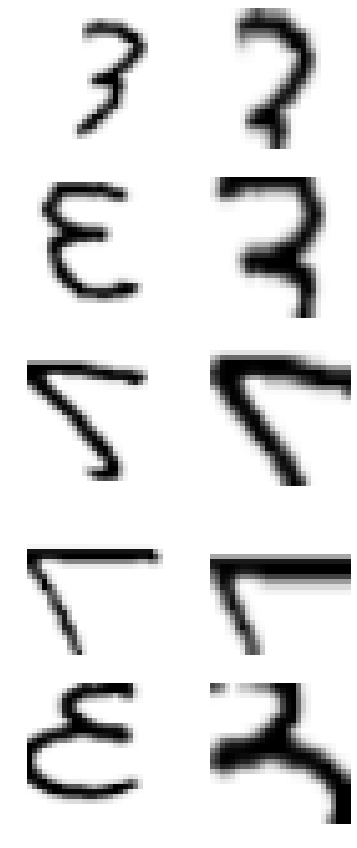

In [ ]:
b = dls.one_batch()
learn._split(b)
learn('before_batch')
axes = learn.barlow_twins.show(n=5)

In [ ]:
learn.fit(1)

In [ ]:
learn.recorder.losses

[tensor(2616.7854)]

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 01 - augmentations.ipynb.
Converted 02 - layers.ipynb.
Converted 03 - distributed.ipynb.
Converted 10 - simclr.ipynb.
Converted 11 - moco.ipynb.
Converted 12 - byol.ipynb.
Converted 13 - swav.ipynb.
Converted 20 - clip.ipynb.
Converted 21 - clip-moco.ipynb.
Converted index.ipynb.
